<a href="https://colab.research.google.com/github/NaviaEddy/PrimerParcial_SIS421/blob/main/PrimerEjercicio_NaviaCondoriEddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICCION DE SERIES TEMPORALES PARA EL RIO QUIRPINCHACA**

# Generamos el Dataset Sintetico

In [119]:
import numpy as np

def generate_synthetic_water_quality_data(batch_size, n_days):
    n_features = 6  # 6 características
    time = np.linspace(0, 1, n_days)
    ica_data = np.zeros((batch_size, n_days, 1), dtype=np.float32)

    for i in range(batch_size):
        # Generar valores aleatorios para las características
        pH = np.random.uniform(7.68, 8.48, size=n_days) # pH
        temperature = np.random.uniform(22.7, 26.3, size=n_days) # Temperatura en °C
        solids = np.random.uniform(369.28, 644.8, size=n_days) / 100  # Sólidos Disueltos Totales
        oxygen = np.random.uniform(1.006, 5.9, size=n_days)  # Oxígeno Disuelto (%)
        nitrates = np.random.uniform(1.8, 8.55, size=n_days) # Nitratos
        turbidity = np.random.uniform(2, 3, size=n_days)  # Turbiedad

        # Calcular el Índice de Calidad del Agua (ICA) sumando todas las características y luego dividiendo entre el número total de características
        ica = (pH + temperature + solids + oxygen + nitrates + turbidity) / n_features

        # Normalizar el ICA entre 0 y 1
        ica_normalized = (ica - np.min(ica)) / (np.max(ica) - np.min(ica))

        # Convertir el ICA normalizado en una onda sinusoidal
        ica_wave = 0.5 * np.sin(2 * np.pi * time * 2)  # Frecuencia de onda de 2

        # Agregar el ICA a los datos
        ica_data[i, :, 0] = ica_wave * ica_normalized

    return ica_data


In [162]:
n_steps = 50
series = generate_synthetic_water_quality_data(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [136]:
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

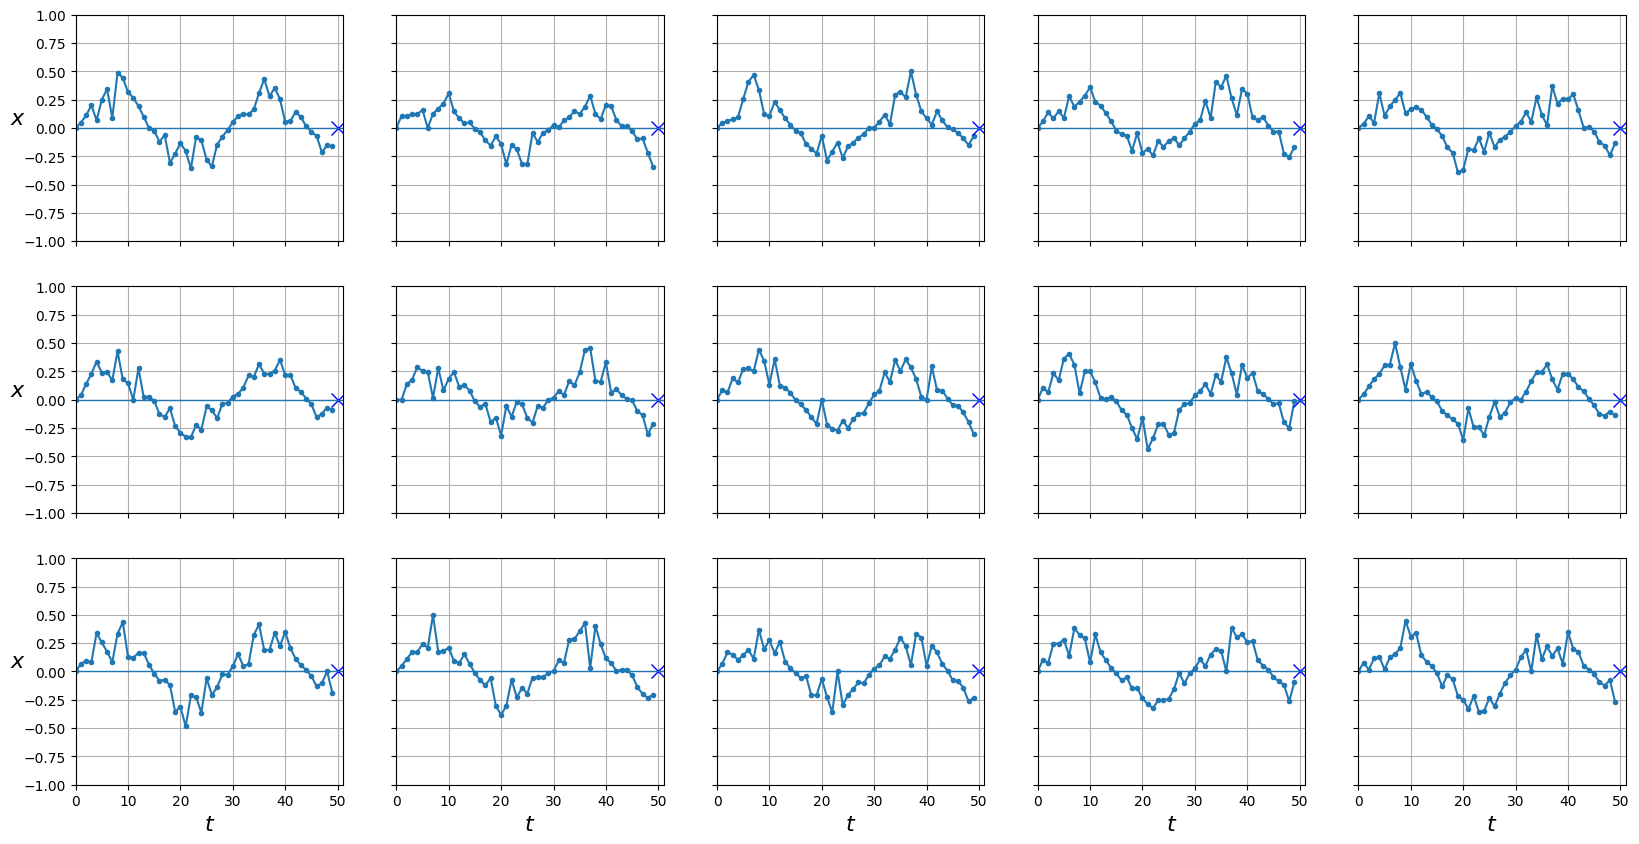

In [226]:
# Utiliza la función plot_series con tus datos
plot_series(X_test, y_test)

In [228]:
from sklearn.metrics import mean_squared_error

y_pred = X_test[:,-1]
mean_squared_error(y_test, y_pred)

0.05443238

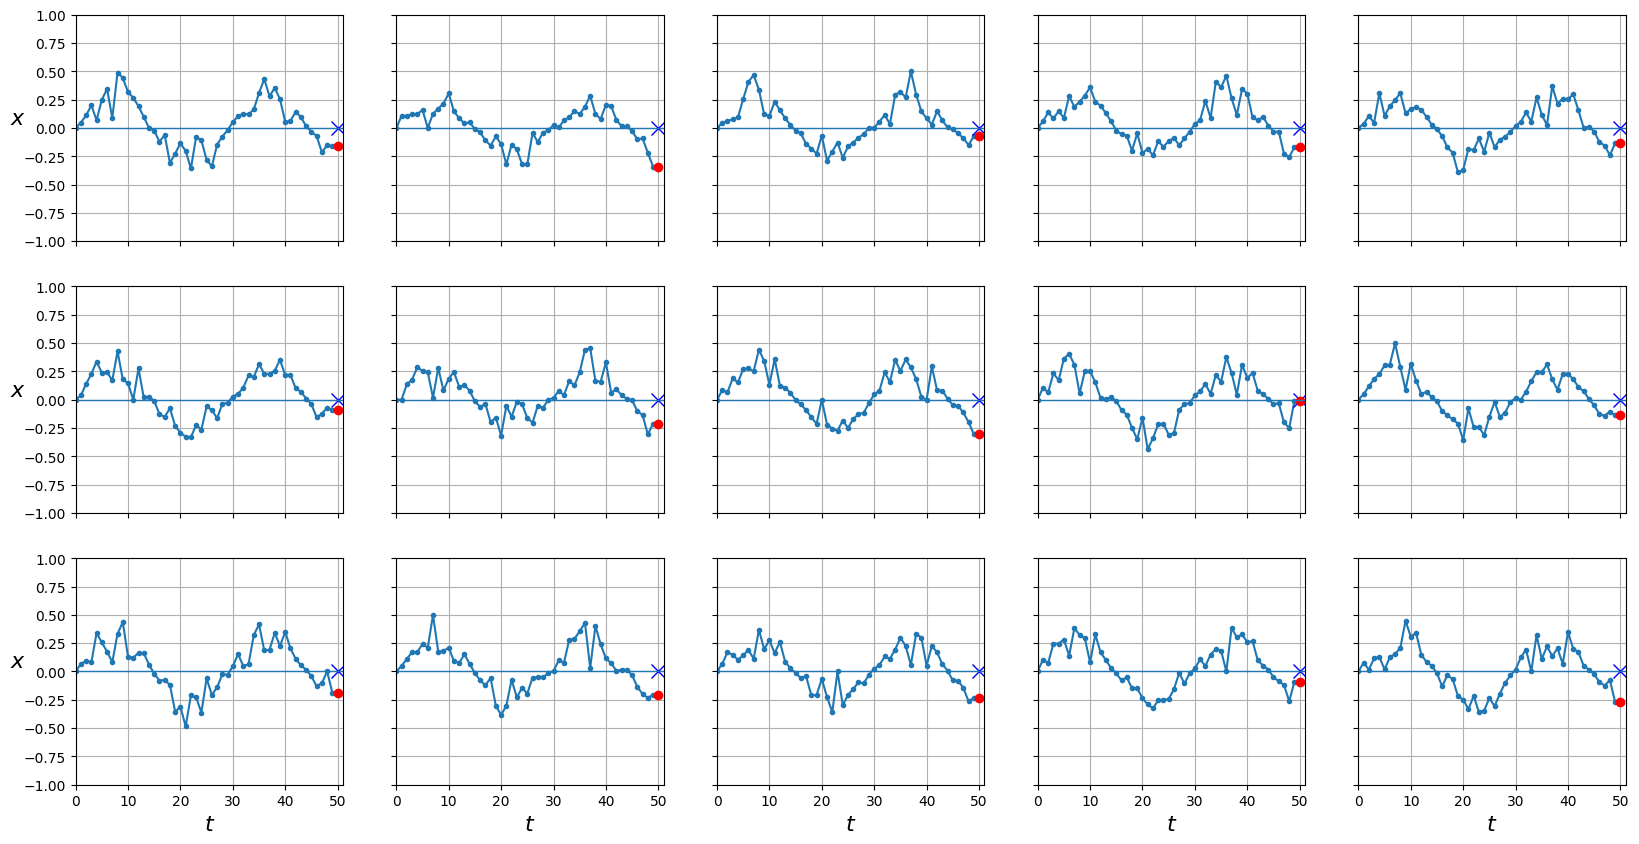

In [229]:
y_pred = X_test[:,-1]
plot_series(X_test, y_test, y_pred)

In [230]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [227]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=50, n_out=1):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

mlp = MLP()
mlp

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [169]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0000002)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [170]:
fit(mlp, dataloader)

loss 0.00195 val_loss 0.00191: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


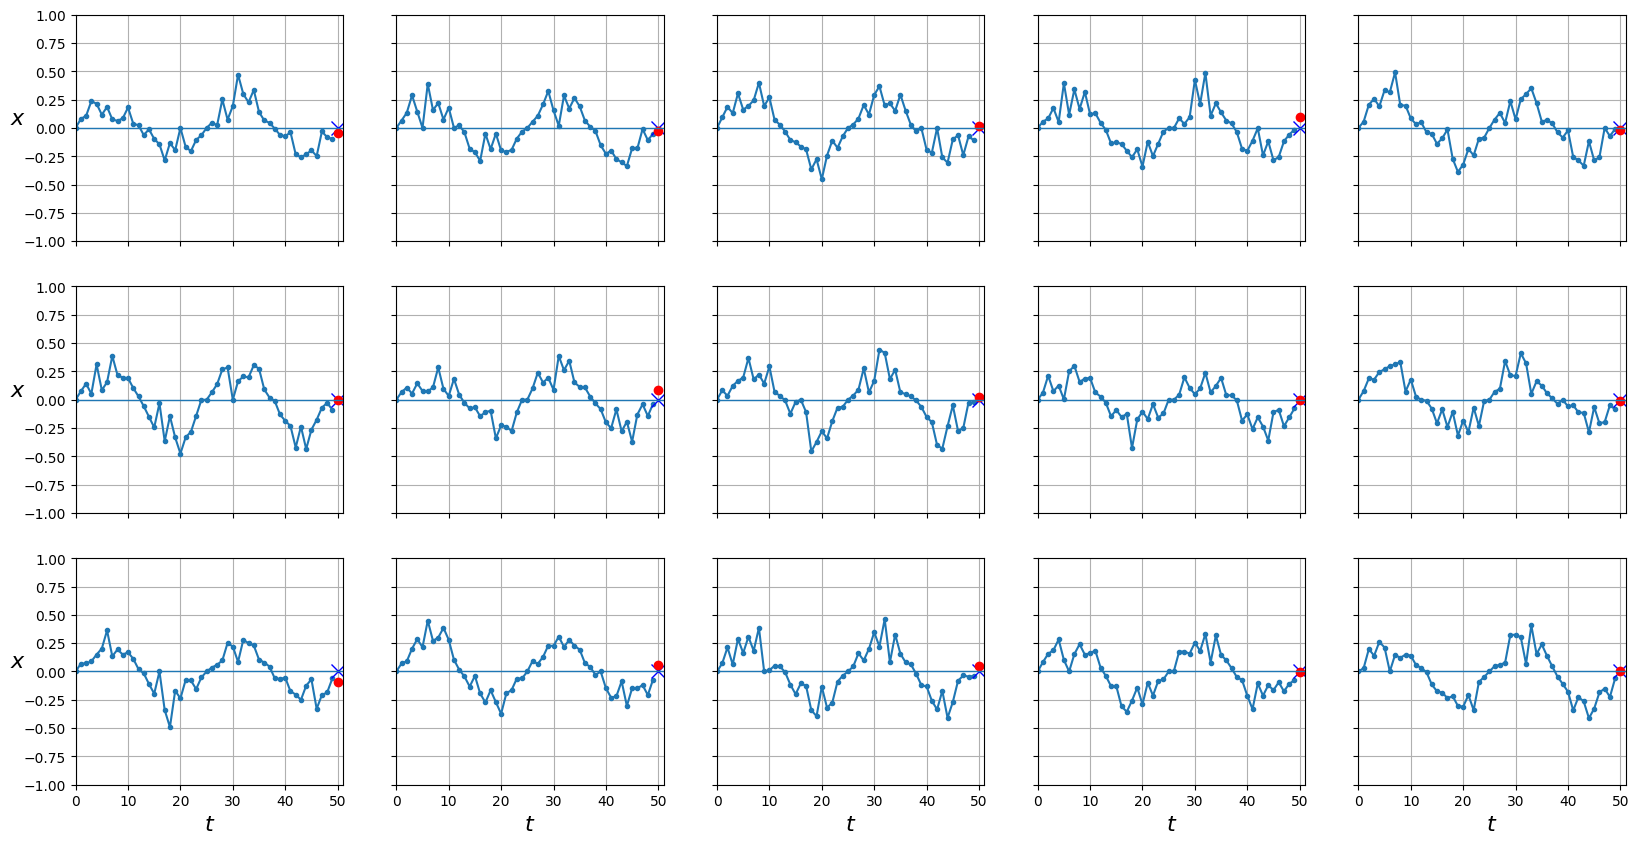

0.002010997

In [171]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

# Generamos los 10 siguientes pasos en el tiempo para cada instante

In [231]:
n_steps = 50
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10), dtype=np.float32)
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [233]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=40, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(40, n_out)

  def forward(self, x):
    x, h = self.rnn(x)
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    # print(x_reshaped.shape)
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

In [217]:
def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")

In [218]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.00716 loss_last_step 0.00783 val_loss 0.00721 val_loss_last_step 0.00808: 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


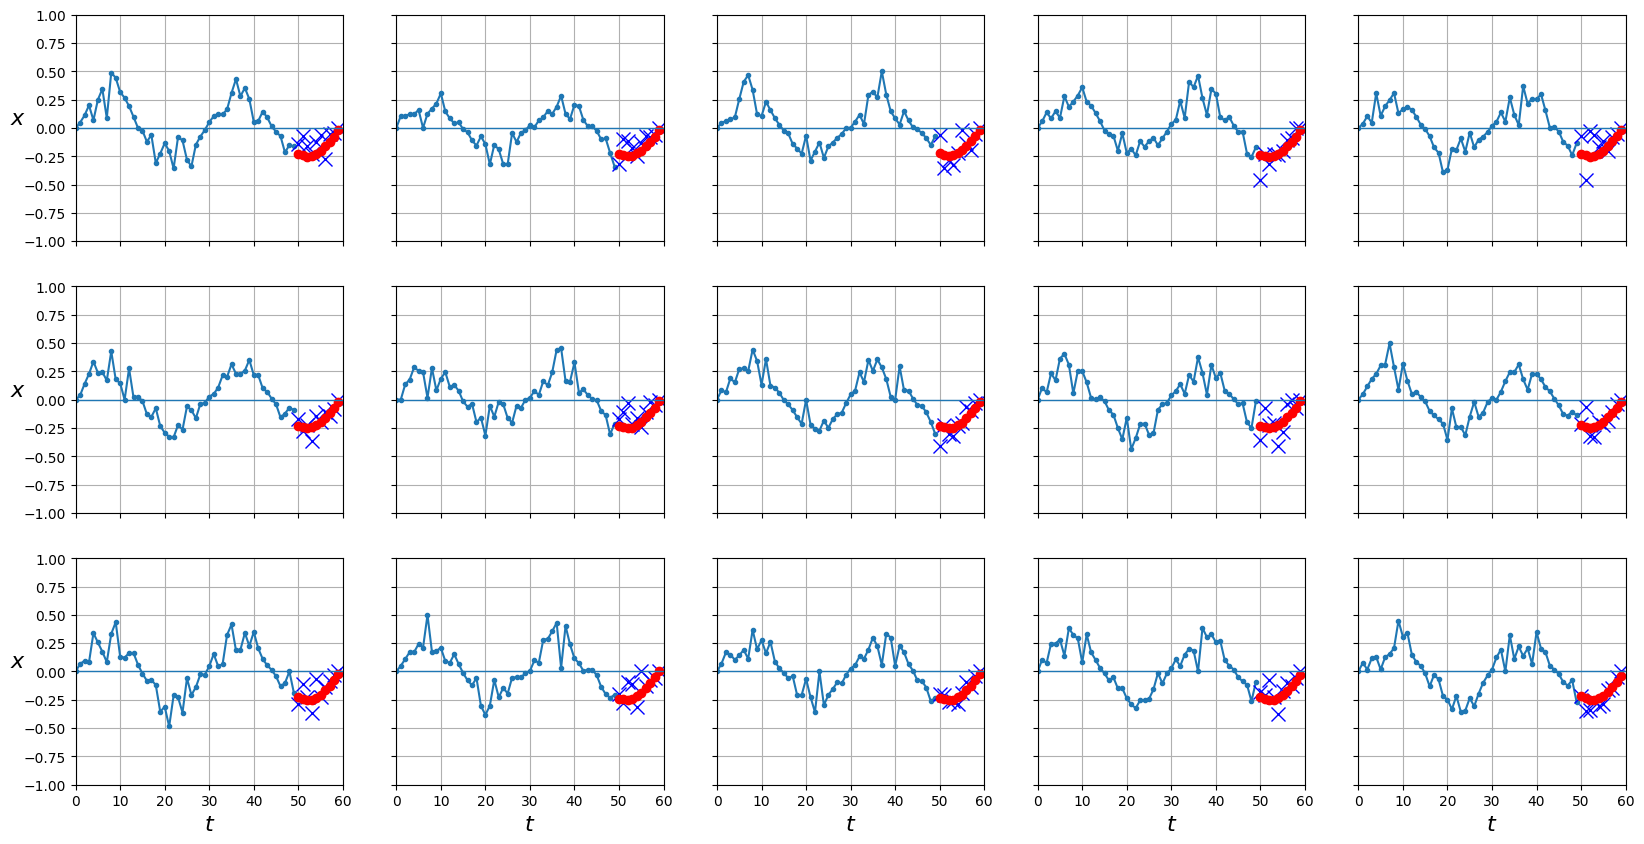

0.008215326

In [219]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, Y_test[:,-1], y_pred[:,-1].cpu().numpy())
mean_squared_error(Y_test[:,-1], y_pred[:,-1].cpu())

# Aplicamos dropout

In [221]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10, dropout=0):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=40, num_layers=2, batch_first=True, dropout=dropout)
    self.fc = torch.nn.Linear(40, n_out)

  def forward(self, x):
    x, h = self.rnn(x)
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

In [222]:
rnn = DeepRNN(dropout=0.3)
fit(rnn, dataloader)

loss 0.00719 loss_last_step 0.00789 val_loss 0.00721 val_loss_last_step 0.00810: 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


In [223]:
def predict(model, dataloader):
    # activar dropout para evaluación !
    model.train() # lo normal aquí es poner model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [224]:
y_preds = np.stack([predict(rnn, dataloader['test']).cpu().numpy() for sample in range(100)])
y_pred = y_preds.mean(axis=0)
y_pred_std = y_preds.std(axis=0)

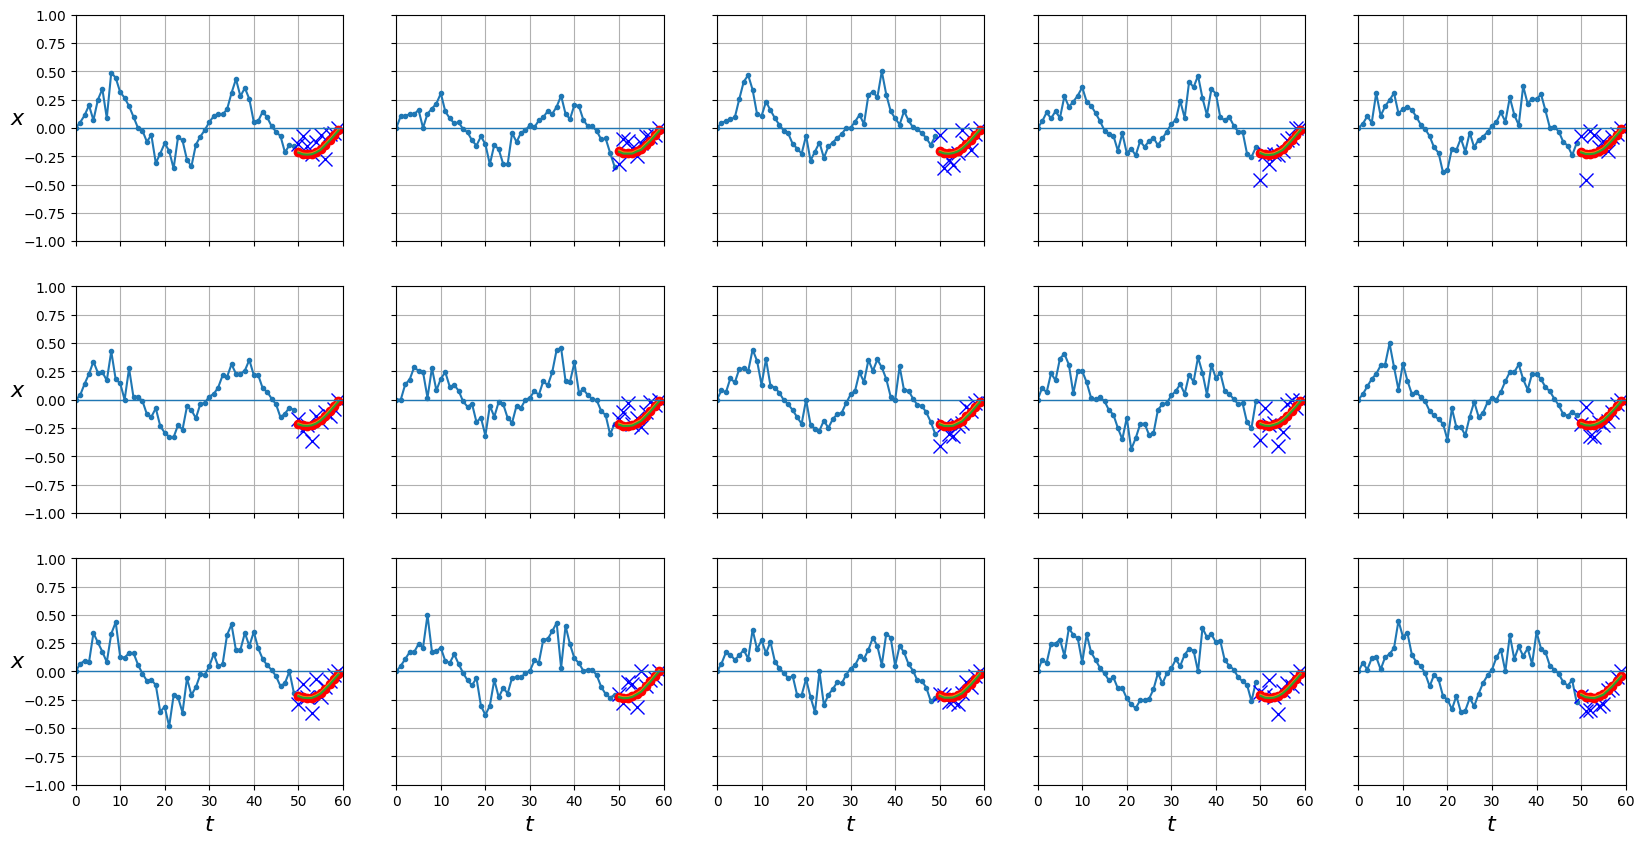

In [225]:
plot_series(X_test, Y_test[:,-1], y_pred[:,-1], y_pred_std[:, -1])